In [2]:
# !usr/bin/python
# -*- encoding: utf-8 -*-
# Project: lONG SHORT-TERM MEMORY
# Author: Tracy Tao
# Date: 2022/04/13

- 三个具有sigmoid激活函数的全连接层处理， 以计算输入门、遗忘门和输出门的值
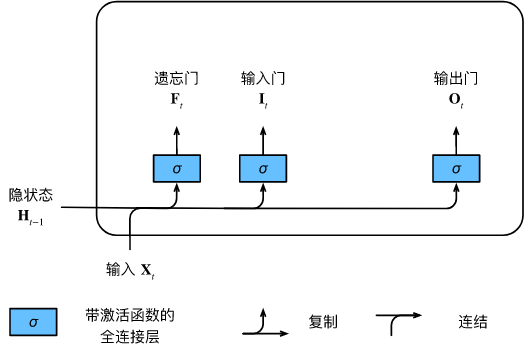
- 候选记忆元，使用tanh函数作为激活函数
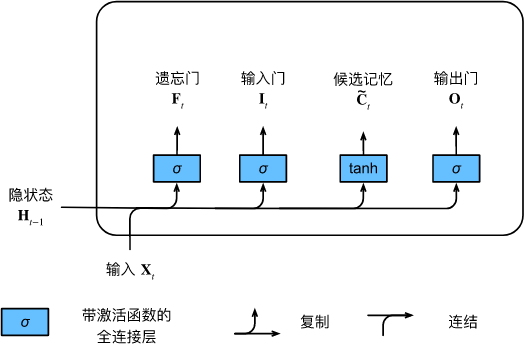
- 将过去记忆保存并传递到当前时间步
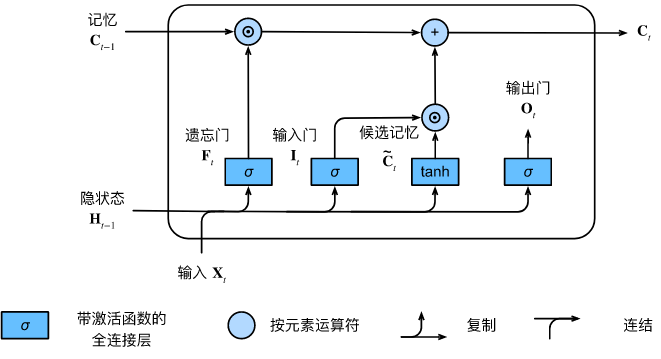
- 隐状态
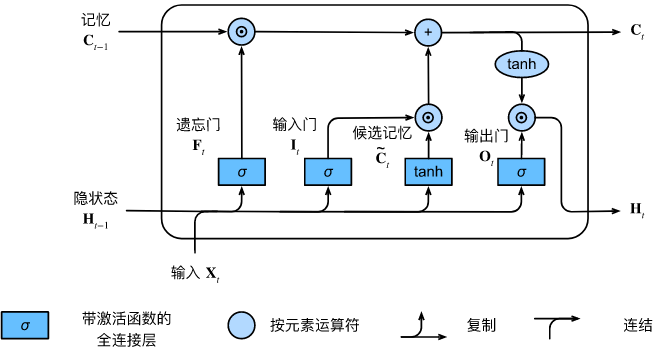

In [3]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [4]:
def get_lstm_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size
    
    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01 # gussian std =0.01
    
    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device)) # init three gate
    
    W_xi, W_hi, b_i = three()  # init input gate
    W_xf, W_hf, b_f = three()  # init foget gate
    W_xo, W_ho, b_o = three()  # init output gate
    W_xc, W_hc, b_c = three()  # init candidate hidden memory cell
    
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    
    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [5]:
def init_lstm_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),
            torch.zeros((batch_size, num_hiddens), device=device))

In [6]:
def lstm(inputs, state, params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c,
     W_hq, b_q] = params
    (H, C) = state
    outputs = []
    for X in inputs:
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)
        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I * C_tilda
        H = O * torch.tanh(C)
        Y = (H @ W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H, C)

In [8]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)

In [9]:
model

RNNModel(
  (rnn): LSTM(28, 256)
  (linear): Linear(in_features=256, out_features=28, bias=True)
)